In [129]:
import torch
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
names = open('names.txt', 'r').read().splitlines()

In [131]:
names[:8], len(names)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [226]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)
block_size = 8
vocab_size = len(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [227]:
def build_dataset(names):
    X, Y = [],[]
    
    for w in names:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # rolling window, makes sense when you run it
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [228]:
import random
random.seed(42)
random.shuffle(names)
X_train, Y_train = build_dataset(names[:int(0.8*len(names))]) #get first 80% of the dataset
X_valid, Y_valid = build_dataset(names[int(0.8*len(names)):int(0.9*len(names))]) # get between 80%-90%
X_test, Y_test = build_dataset(names[int(0.9*len(names)):]) # get last 10% of dataset

torch.manual_seed(42);

In [242]:
class Linear:
                     #examples,#neurons
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params, (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers, (trained with a running momentum)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True) # batch mean
            xvar = x.var(0, keepdims=True, unbiased=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma*(xhat + self.beta)
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean*(1-self.momentum) + xmean*self.momentum
                self.running_var = self.running_var*(1-self.momentum) + xvar*self.momentum
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
      
  def parameters(self):
    return []

# replaces emb = C[Xb]
class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim)) # 27, 10
    def __call__(self, IX):
        self.out = self.weight[IX] # 4, 8, 10. For each 1/8 chars, in each 1/4 examples, we pick out the correct length 10 vector
        return self.out

    def parameters(self):
        return [self.weight]

# old: replaces x = emb.view(emb.shape[0],-1)
# new: flattens n adjacent elements (rows) together and concatenates their vectors (2 for bigrams)
class FlattenConsecutive: 
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape # B = batch size = 4 (in the example) 
                          # T = length of the sequence (tracking 8 chars) 
                          # C = Channels = features = 10 [vector length / features for each char]
        x = x.view(B, T//self.n, C*self.n) # batch size (same)
                                        # sequence length (8) // n; if we merge each 2 elements together, we get 2x less "chars"
                                        # features * n; if n = 2, we get 2x bigger vector length for each new "char" (bigram)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
        
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [246]:
n_emb = 10
n_hidden = 68

myNet = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(2), Linear(2 * n_emb, n_hidden,  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden,  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden,  bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3
parameters = myNet.parameters()
print(sum(p.numel() for p in parameters)) # number of parms in total
for p in parameters:
   p.requires_grad = True

22397


In [247]:
ix = torch.randint(0, X_train.shape[0],(4,))
Xb, Yb = X_train[ix], Y_train[ix]
print(Xb.shape)
logits = myNet(Xb)
loss = F.cross_entropy(logits, Yb)
print(loss)

torch.Size([4, 8])
tensor(3.6563, grad_fn=<NllLossBackward0>)


In [248]:
for layer in myNet.layers:
    print(f"{layer.__class__.__name__} : {tuple(layer.out.shape)}")

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [249]:
# optimization
max_steps = 100000
batch_size = 32
lossi = []
ud = [] # update:data ratio (lr*gradient).std / parameter.data.std
    
for i in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    
    logits = myNet(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    #for layer in myNet.layers:
     #  layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps/2 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # if i >= 199:
    #     break
print(f"training loss: {loss}")
#print(ud)

      0/ 100000: 3.4858
  10000/ 100000: 2.2798
  20000/ 100000: 2.3413
  30000/ 100000: 2.5213
  40000/ 100000: 2.6037
  50000/ 100000: 1.9931
  60000/ 100000: 1.9296
  70000/ 100000: 2.3412
  80000/ 100000: 2.4058
  90000/ 100000: 1.9085
training loss: 1.6822854280471802


In [250]:
loss_averaged = torch.tensor(lossi).view(200,-1).mean(dim=1)
#len(lossi)

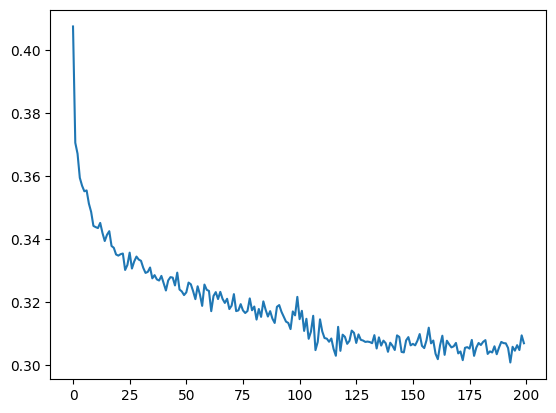

In [251]:
plt.plot(loss_averaged)

In [252]:
# eval loss on full training data set after training
#------------
logits = myNet(X_valid)
loss = F.cross_entropy(logits, Y_valid)
print(loss)

tensor(2.0579, grad_fn=<NllLossBackward0>)


In [253]:
logits = myNet(X_test)
loss = F.cross_entropy(logits, Y_test)
print(loss)

tensor(2.0684, grad_fn=<NllLossBackward0>)


In [255]:
# To end this off, let's sample from the model
#------------
for layer in myNet.layers:
    layer.training = False
    
block_size = 8
#g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = myNet(torch.tensor([context]))
        probs = F.softmax(logits,dim=1) # same as before, exponentiates, makes them sum to 1
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix] # sliding window again
        out.append(ix)
        if(ix == 0):
            break
    print(''.join(itos[i] for i in out))

shantin.
abian.
zurije.
sorina.
ketun.
daiga.
elia.
ayona.
kahlinn.
asebpa.
carlan.
sapping.
myjana.
glain.
jezynn.
josa.
aliil.
rezha.
phanash.
marius.


In [164]:
e = torch.randn(4,8,10)   # instead of having this, let's try to make it 4,4,20, where 10d vectors get concatenated
explicit = torch.cat((e[:,::2,], e[:,1::2,:]), dim=2) # gets all even chars, and all odd chars, and concatenates their 10 vectors

# 0 , 2 , 4 , 6 , 8
# 1 , 3 , 5 , 7 , 9
# 0+1, 2+3, 4+5, 6+7, 8+9 (except it's their vectors we are concatenating)

In [168]:
viewed = e.view(4,4,-1)
(viewed == explicit).all() # exact same thing

tensor(True)